In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import rich
import colorcet as cc
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from importlib import reload
from typing import List, Dict, Tuple
import celeri

plt.rcParams["text.usetex"] = False

# Read input, create data structures, close blocks


In [3]:
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

# Hack
segment.locking_depth = 15
segment.burial_depth = 0
segment.locking_depth.values[segment.patch_flag == 1] = 0
segment.burial_depth.values[segment.patch_flag == 1] = 0

station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

INFO: Read: ../data/command/western_north_america_command.json - celeri.celeri:get_logger:7860 - 2025-05-12 21:36:36
INFO: RUN_NAME: 0000001120 - celeri.celeri:get_logger:7861 - 2025-05-12 21:36:36
INFO: Write log file: ../runs/0000001120/0000001120.log - celeri.celeri:get_logger:7862 - 2025-05-12 21:36:36
INFO: Reading data files - celeri.celeri:read_data:441 - 2025-05-12 21:36:36
SUCCESS: Read: ../data/segment/western_north_america_segment_cascdip.csv - celeri.celeri:read_data:445 - 2025-05-12 21:36:36
SUCCESS: Read: ../data/block/western_north_america_block.csv - celeri.celeri:read_data:450 - 2025-05-12 21:36:36
SUCCESS: Read: ../data/mesh/western_north_america_mesh_parameters.json - celeri.celeri:read_data:457 - 2025-05-12 21:36:36

SUCCESS: Read: ../data/mesh/cascadia.msh - celeri.celeri:read_mesh:436 - 2025-05-12 21:36:36
SUCCESS: Read: ../data/station/western_north_america_station.csv - celeri.celeri:read_data:525 - 2025-05-12 21:36:36
INFO: No mogi_file_name - celeri.celeri:rea

# Get elastic operators and TDE smoothing operators


In [4]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

INFO: Using precomputed elastic operators - celeri.celeri:get_elastic_operators:2007 - 2025-05-12 21:36:37


# Calculate non-elastic operators


In [5]:
n_blocks = len(block)
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, n_blocks
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

INFO: Found 1 slip rate constraints - celeri.celeri:get_slip_rate_constraints:3271 - 2025-05-12 21:36:37
INFO: Strike-slip rate constraint on cfm_san_andreas_mojave_extruded_trace_part1_sa: rate = -50.00 (mm/yr), 1-sigma uncertainty = +/-1.00 (mm/yr) - celeri.celeri:get_slip_rate_constraints:3274 - 2025-05-12 21:36:37


# Plot input data


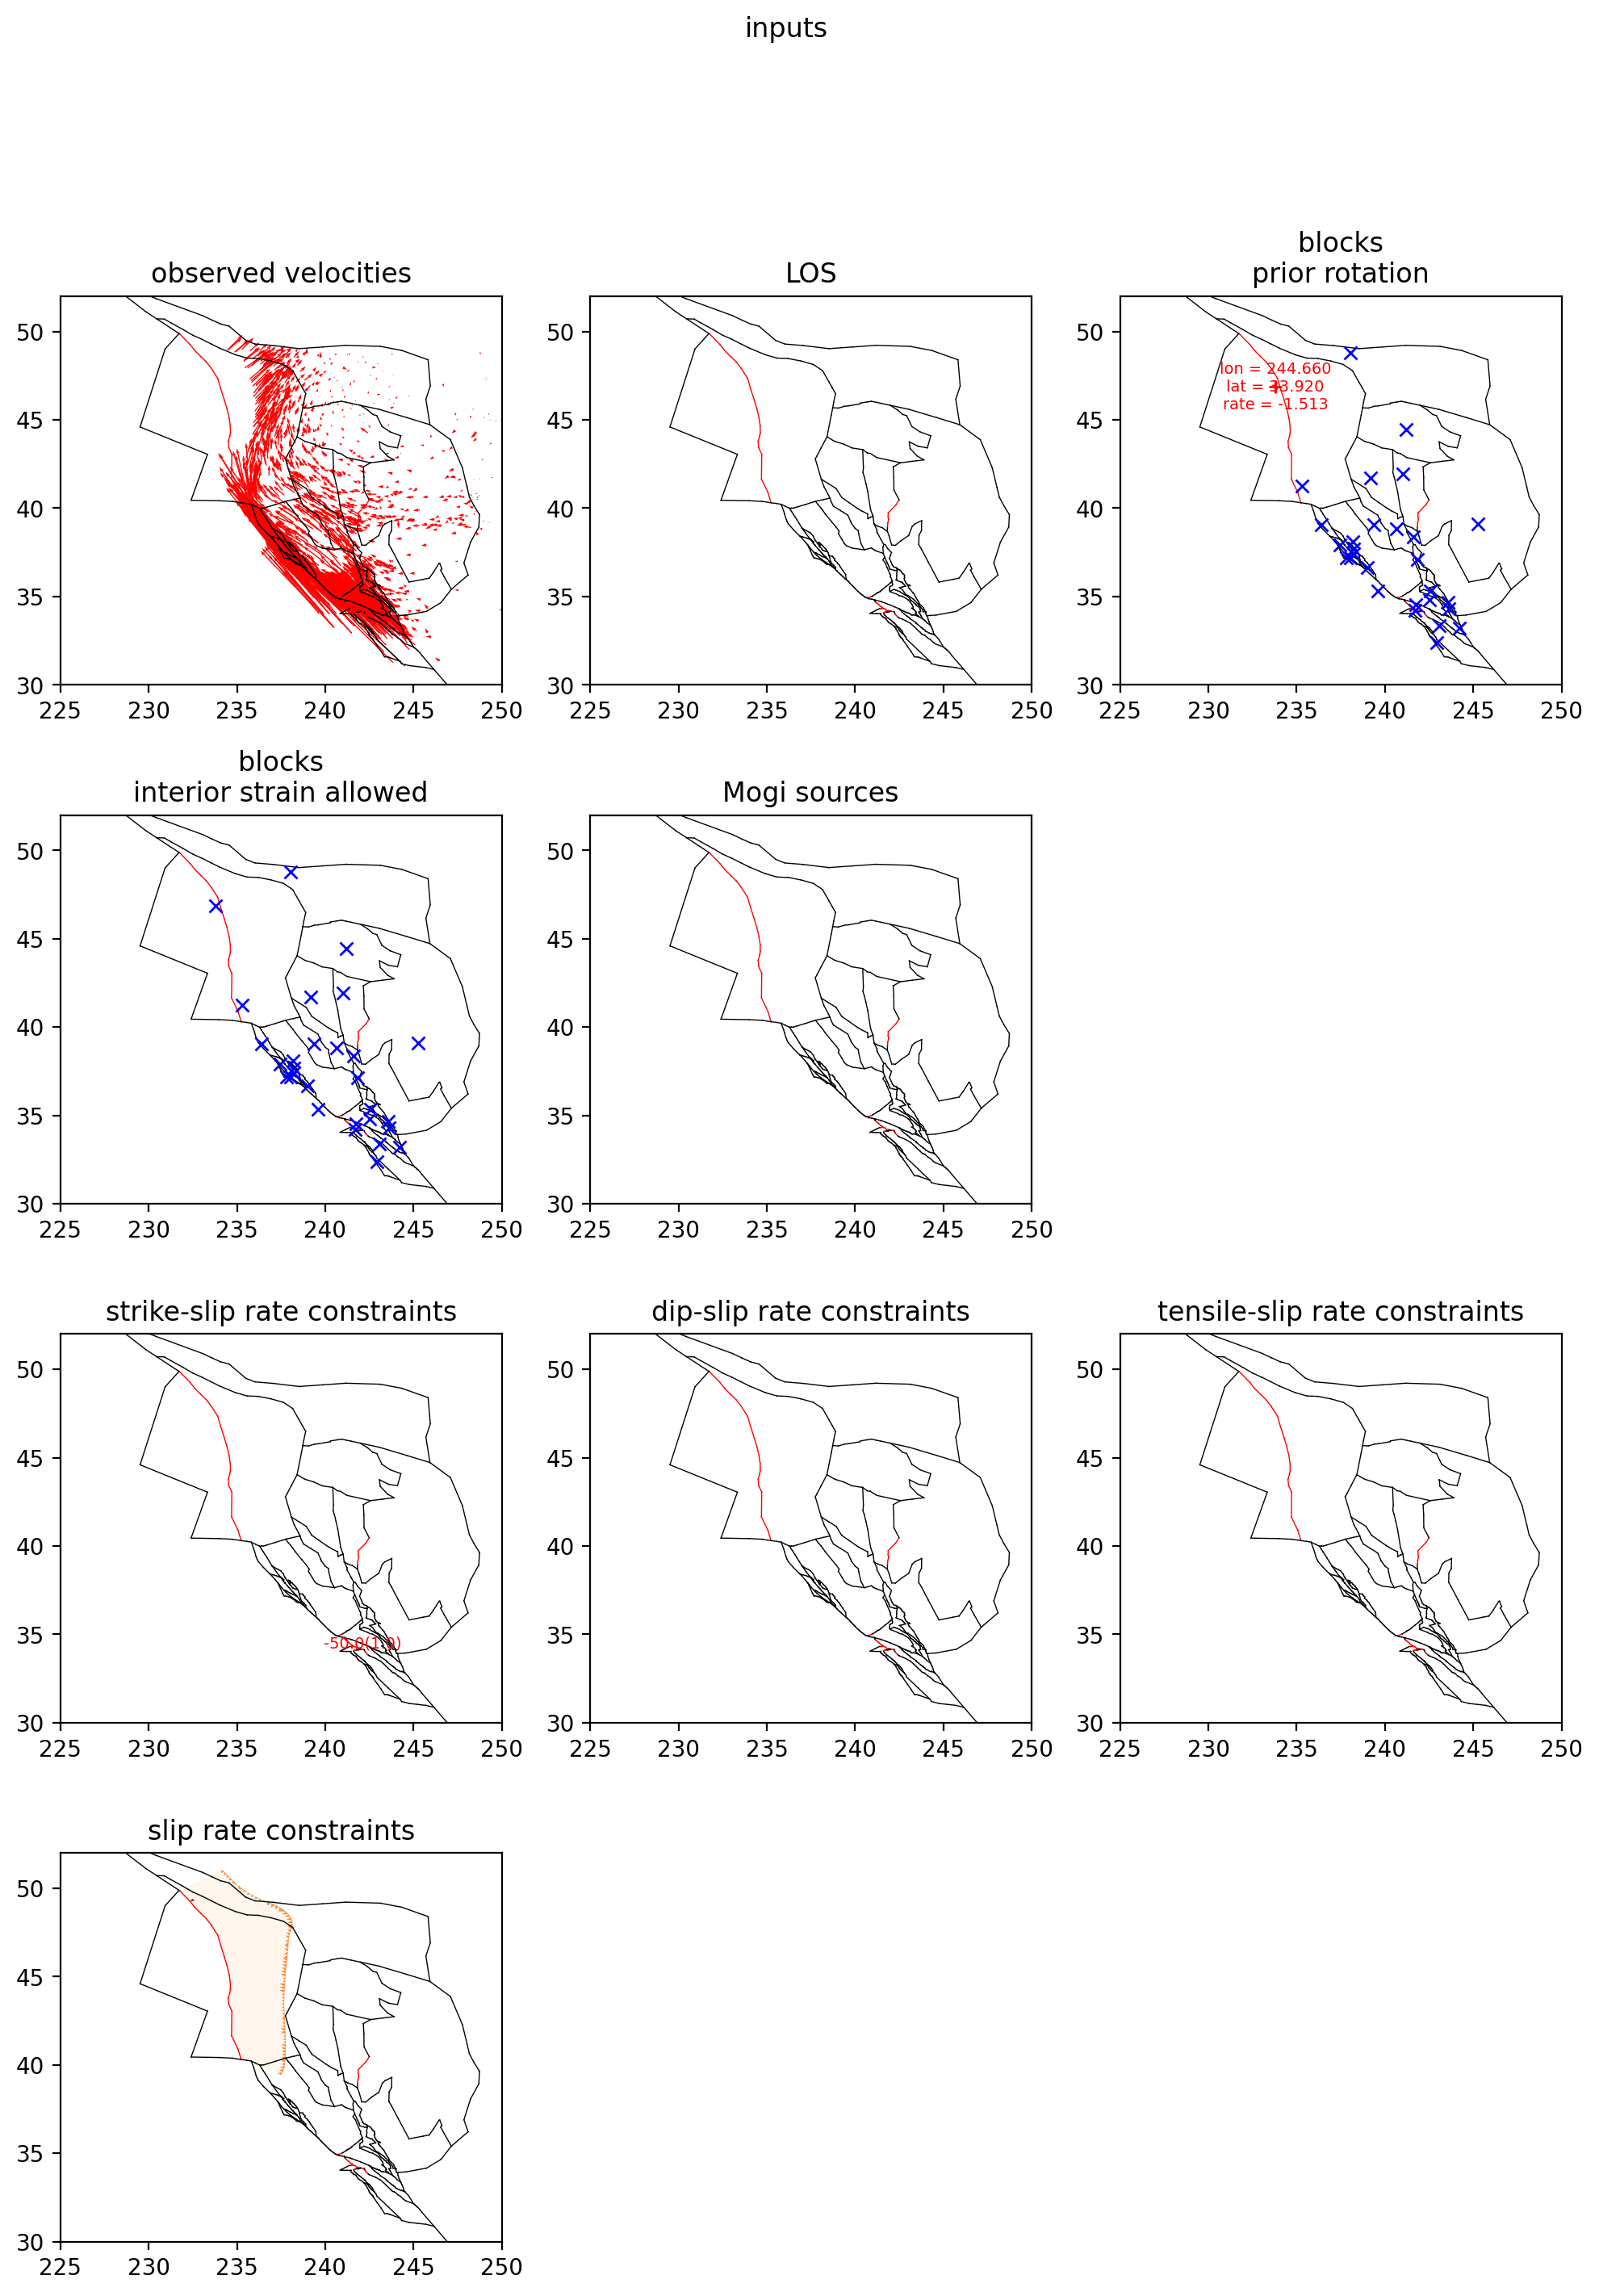

SUCCESS: Wrote figures../runs/0000001120/plot_input_summary.(pdf, png) - celeri.celeri:plot_input_summary:6568 - 2025-05-12 21:36:39


<Figure size 640x480 with 0 Axes>

In [6]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Estimate block model parameters (dense)


In [7]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes, mogi
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary


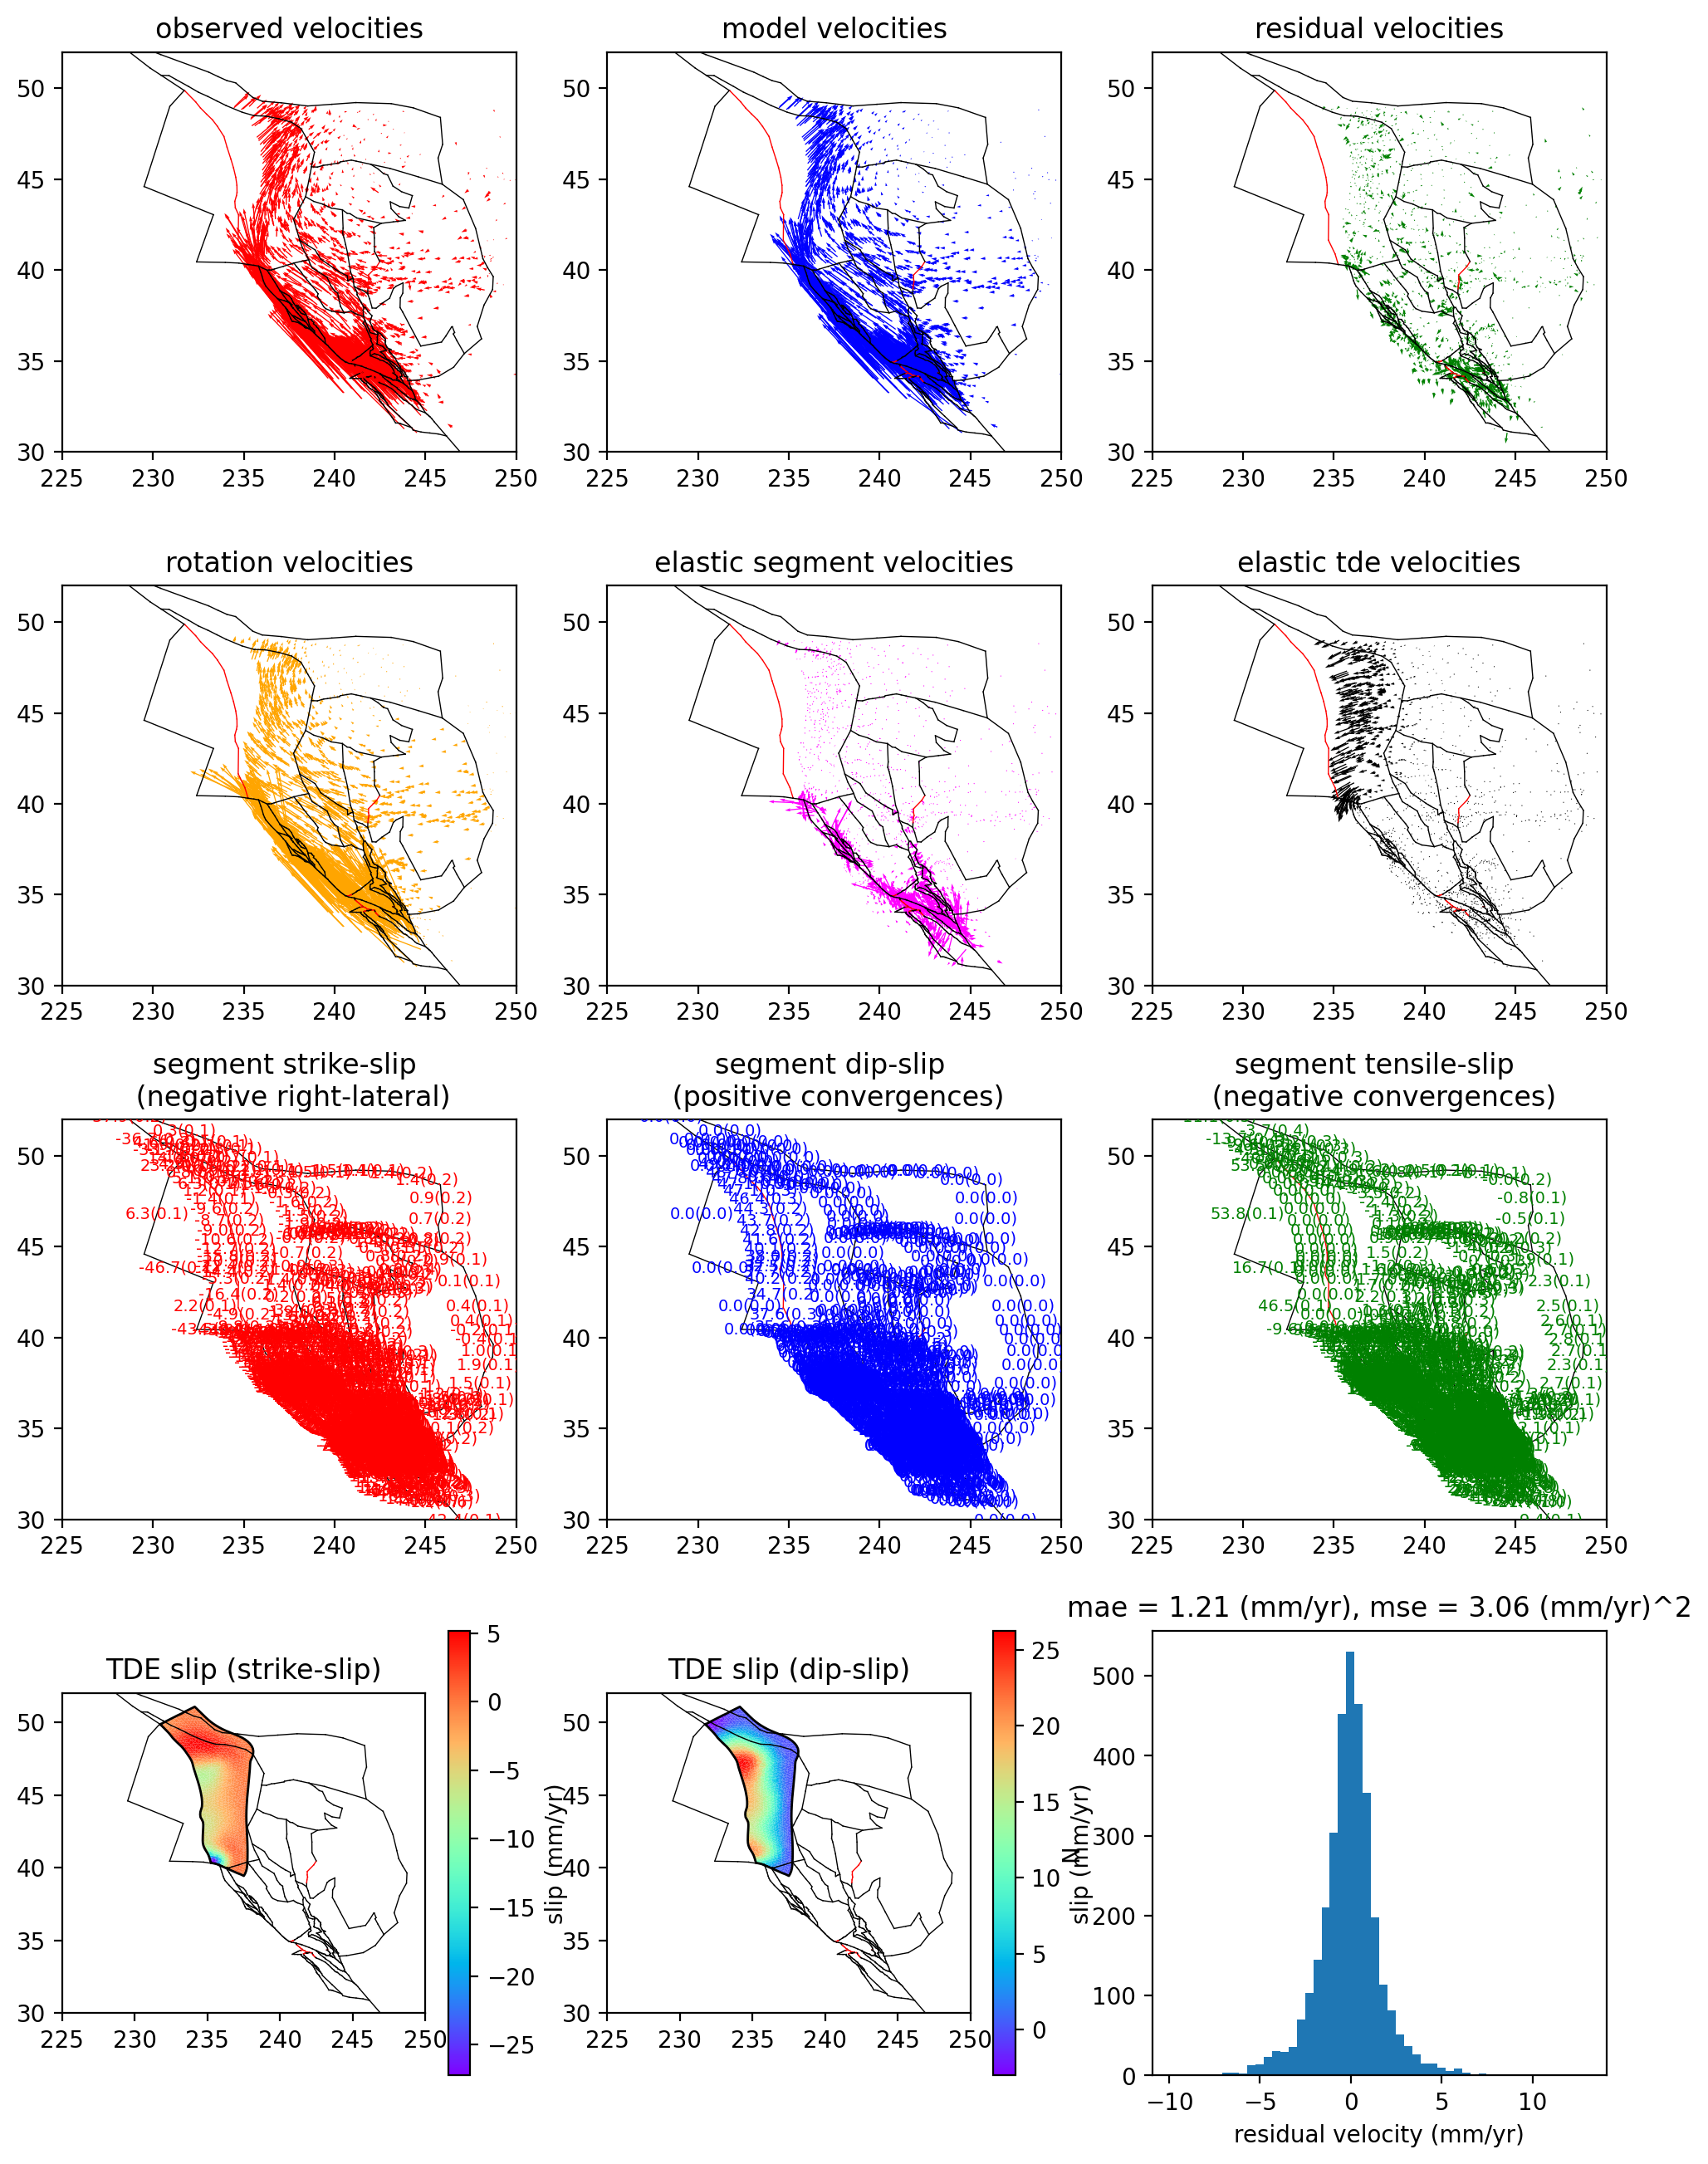

SUCCESS: Wrote figures../runs/0000001120/plot_estimation_summary.(pdf, png) - celeri.celeri:plot_estimation_summary:6908 - 2025-05-12 21:36:43


<Figure size 640x480 with 0 Axes>

In [8]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)

# Start of KL approach

In [11]:
meshes[0].keys()

dict_keys(['file_name', 'points', 'verts', 'lon1', 'lon2', 'lon3', 'lat1', 'lat2', 'lat3', 'dep1', 'dep2', 'dep3', 'centroids', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x_centroid', 'y_centroid', 'z_centroid', 'lon_centroid', 'lat_centroid', 'nv', 'strike', 'dip', 'dip_flag', 'n_tde', 'areas', 'mesh_filename', 'smoothing_weight', 'n_modes_strike_slip', 'n_modes_dip_slip', 'top_slip_rate_constraint', 'bot_slip_rate_constraint', 'side_slip_rate_constraint', 'top_slip_rate_weight', 'bot_slip_rate_weight', 'side_slip_rate_weight', 'a_priori_slip_filename', 'ss_slip_constraint_idx', 'ss_slip_constraint_rate', 'ss_slip_constraint_sig', 'ss_slip_constraint_weight', 'ds_slip_constraint_idx', 'ds_slip_constraint_rate', 'ds_slip_constraint_sig', 'ds_slip_constraint_weight', 'coupling_constraint_idx', 'coupling_constraint_frac', 'coupling_constraint_sigma', 'coupling_constraint_weight', 'qp_mesh_tde_bound', 'qp_mesh_tde_slip_rate_lower_bound_ss', 'qp_mesh_tde_slip_rate_upper_bound_s

In [ ]:
import scipy


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-distance_matrix)

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


# Calculate eigenvales and eigenvectors for triangle subset
# n_eigenvalues = meshes[0].n_tde
# n_eigenvalues = 20


eigenvalues, eigenvectors = get_eigenvalues_and_eigenvectors(
    meshes[0].n_modes_strike_slip,
    meshes[0].x_centroid,
    meshes[0].y_centroid,
    meshes[0].z_centroid,
)

TypeError: unsupported operand type(s) for -: 'int' and 'Dict'

In [ ]:
# Create modified eigenvector matrix here
# This is a replication of the EVs for both slip components
# There are other ways to do this but as implemented is a sort of
# checkerboard like pattern.  The column indexing an every other
# row striding implements this.
eigenvectors_two_component = np.zeros(
    (2 * eigenvectors.shape[0], 2 * eigenvectors.shape[1])
)
for i in range(meshes[0].n_eigen):
    index_column_1 = 2 * i
    index_column_2 = 2 * i + 1
    eigenvectors_two_component[0::2, index_column_1] = eigenvectors[:, i]
    eigenvectors_two_component[1::2, index_column_2] = eigenvectors[:, i]

# Assemble linear system for KL case

In [ ]:
DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e6  # TODO: What should this conversion be?


def get_data_vector_eigen(assembly, index):
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints
    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    for i in range(len(meshes)):
        # TODO: This is too hacky to keep.  Revise with no reference to smoothing
        weighting_vector[
            index.start_tde_smoothing_row[i] : index.start_tde_smoothing_row[i]
            + index.n_tde_constraints[i]
        ] = command.tri_con_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator

    n_eigen = eigenvectors_two_component.shape[1] / 2
    print(f"{n_eigen=}")

    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            # + 2 * index.n_tde_total
            + index.n_tde_constraints_total,
            3 * index.n_blocks + 2 * int(n_eigen),
        )
    )
    print(f"{eigenvectors_two_component.shape=}")
    print(f"{operator.shape=}")

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # Insert eigenvector to velocity matrix
    tde_keep_row_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[0]
    )
    tde_keep_col_index = celeri.get_keep_index_12(
        operators.tde_to_velocities[0].shape[1]
    )
    eigen_to_velocities = (
        -operators.tde_to_velocities[0][tde_keep_row_index, :][:, tde_keep_col_index]
        @ eigenvectors_two_component
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_velocities

    # Insert eigenvector to TDE constraints matrix
    # TODO: Inherit weighting from mesh_parameters file
    NNN = 1e1
    eigen_to_tde_slip_rate_constraints = (
        NNN * operators.tde_slip_rate_constraints[0] @ eigenvectors_two_component
    )

    operator[
        index.start_slip_rate_constraints_row : index.start_slip_rate_constraints_row
        + index.n_tde_constraints_total,
        index.start_tde_col[0] : index.start_tde_col[0] + 2 * meshes[0].n_eigen,
    ] = eigen_to_tde_slip_rate_constraints

    # # Insert TDE to velocity matrix
    # for i in range(len(meshes)):
    #     # Insert TDE to velocity matrix
    #     tde_keep_row_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[0])
    #     tde_keep_col_index = celeri.get_keep_index_12(operators.tde_to_velocities[i].shape[1])
    #     operator[
    #         index.start_station_row : index.end_station_row,
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = -operators.tde_to_velocities[i][tde_keep_row_index, :][
    #         :, tde_keep_col_index
    #     ]

    #     # # Insert TDE smoothing matrix
    #     # smoothing_keep_index = celeri.get_keep_index_12(
    #     #     operators.tde_to_velocities[i].shape[1]
    #     # )
    #     # operator[
    #     #     index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i],
    #     #     index.start_tde_col[i] : index.end_tde_col[i],
    #     # ] = operators.smoothing_matrix[i].toarray()[smoothing_keep_index, :][
    #     #     :, smoothing_keep_index
    #     # ]

    #     # Insert TDE slip rate constraints into estimation operator
    #     operator[
    #         index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i],
    #         index.start_tde_col[i] : index.end_tde_col[i],
    #     ] = operators.tde_slip_rate_constraints[i]
    return operator


data_vector = celeri.get_data_vector(assembly, index, meshes)
data_vector_eigen = get_data_vector_eigen(assembly, index)
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)
operator = celeri.get_full_dense_operator(operators, meshes, index)
operator_eigen = get_full_dense_operator_eigen(operators, meshes, index)

n_eigen=20.0
eigenvectors_two_component.shape=(3682, 40)
operator.shape=(3519, 133)


In [ ]:
def post_process_estimation_eigen(
    estimation_eigen: Dict, operators: Dict, station: pd.DataFrame, index: Dict
):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    # TODO: Start working through this for the EV case
    estimation_eigen.eigenvalues = estimation_eigen.state_vector[3 * n_blocks : :]
    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )
    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    estimation_eigen.slip_rate_sigma = np.sqrt(
        np.diag(
            operators.rotation_to_slip_rate
            @ estimation_eigen.state_covariance_matrix[
                0 : 3 * index.n_blocks, 0 : 3 * index.n_blocks
            ]
            @ operators.rotation_to_slip_rate.T
        )
    )  # I don't think this is correct because for the case when there is a rotation vector a priori
    estimation_eigen.strike_slip_rate_sigma = estimation_eigen.slip_rate_sigma[0::3]
    estimation_eigen.dip_slip_rate_sigma = estimation_eigen.slip_rate_sigma[1::3]
    estimation_eigen.tensile_slip_rate_sigma = estimation_eigen.slip_rate_sigma[2::3]

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = (
        eigenvectors_two_component @ estimation_eigen.state_vector[3 * n_blocks : :]
    )
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # TODO: Calculate block strain rate velocities
    estimation_eigen.east_vel_block_strain_rate = np.zeros(len(station))
    estimation_eigen.north_vel_block_strain_rate = np.zeros(len(station))

    # Calculate TDE velocities
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):

        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )
        estimation_eigen.vel_tde += (
            operators.tde_to_velocities[i][tde_keep_row_index, :][:, tde_keep_col_index]
            @ eigenvectors_two_component
            @ estimation_eigen.state_vector[
                index.start_tde_col[i] : index.end_tde_col[i]
            ]
            # @ estimation_eigen.eigenvalues
        )
    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]


# Solve the linear system
estimation_eigen = addict.Dict()
estimation_eigen.state_covariance_matrix = np.linalg.inv(
    operator_eigen.T * weighting_vector_eigen @ operator_eigen
)
estimation_eigen.state_vector = (
    estimation_eigen.state_covariance_matrix
    @ operator_eigen.T
    * weighting_vector_eigen
    @ data_vector_eigen
)
forward_data_vector_eigen = operator_eigen @ estimation_eigen.state_vector

estimation_eigen.operator = operator_eigen
post_process_estimation_eigen(estimation_eigen, operators, station, index)

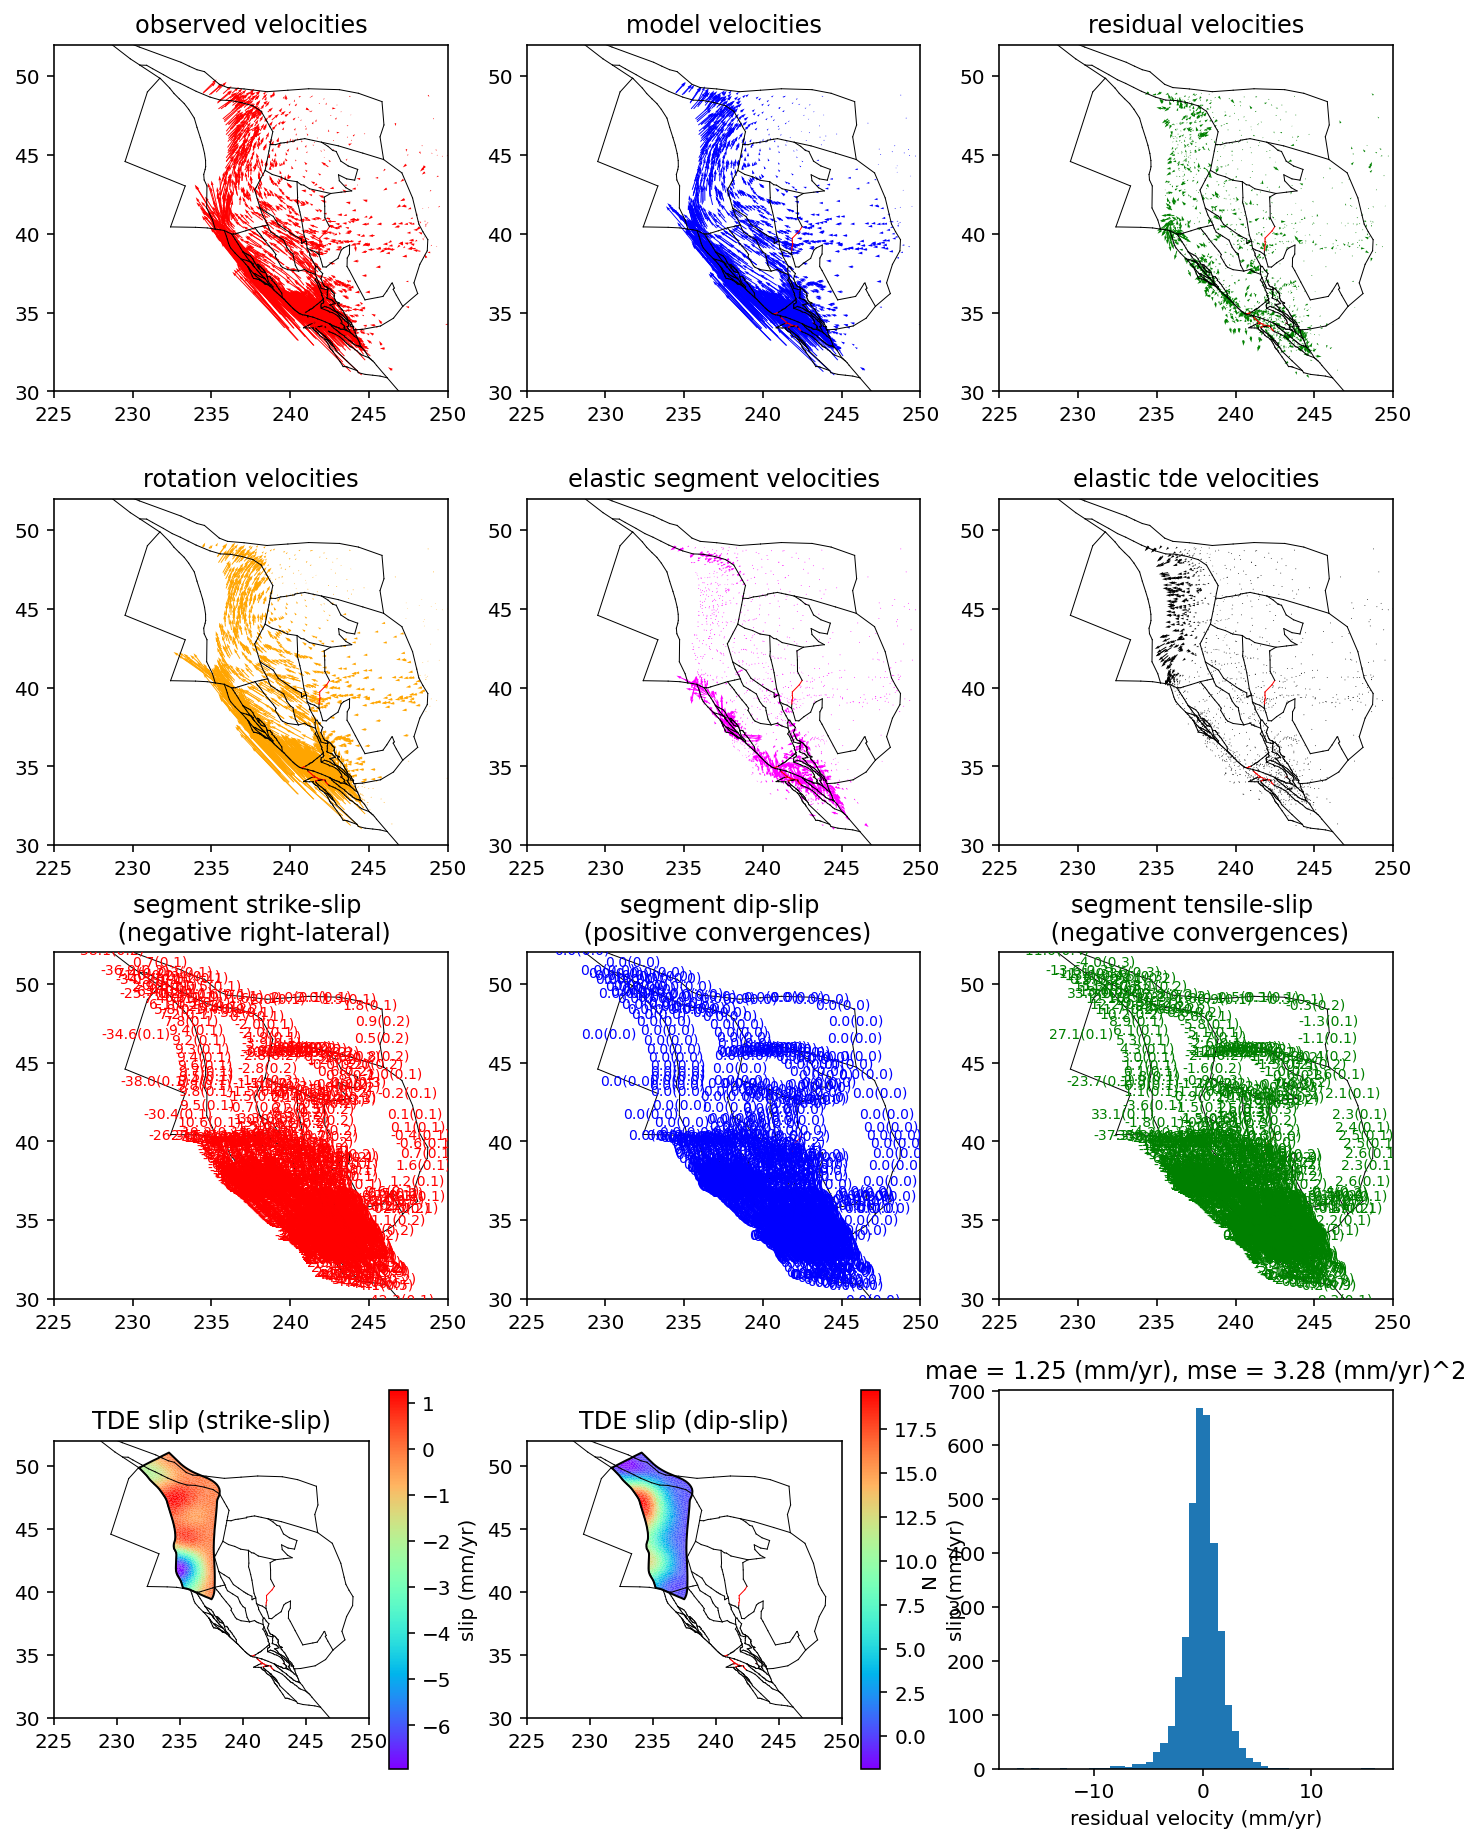

2024-06-04 14:06:19.000 | SUCCESS  | celeri.celeri:plot_estimation_summary:4915 - Wrote figures../runs/2024-06-04-14-05-55/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [ ]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_eigen,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)